In [1]:
from mt5 import MT5Config,MT5Generation
from utils.utils import compute_rouge
import pickle
import torch
from tqdm import tqdm
from t5tokenization import T5Tokenizer
from pythonicforbert import get_model_function,FullTokenizer
from loader_mt5 import load_mt5_generation_data
from torch.utils.data import Dataset,DataLoader
from mt5 import greedy_generate
import json
vocab_file = r'/home/xiaoguzai/模型/t5-copy/vocab.txt'
vocab_size = len(open(vocab_file,'r').readlines()) 
with open('/home/xiaoguzai/模型/t5-copy/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
json_data['vocab_size'] = vocab_size
train_feat = []
valid_feat = []
mt5config = MT5Config(**json_data)
t5tokenizer = FullTokenizer(vocab_file=vocab_file)
for num in range(10):
    train_feat = train_feat+pickle.load(open("/media/xiaoguzai/WD_BLACK/毕业设计抽取摘要结果数据/train_feat_"+str(num)+".pkl","+rb"))
for num in range(10):
    valid_feat = valid_feat+pickle.load(open("/media/xiaoguzai/WD_BLACK/毕业设计抽取摘要结果数据/valid_feat_"+str(num)+".pkl","+rb"))

In [2]:
config_params = \
{
    'train_batch_size':8,
    'generate_abstract_max_length':500,
    'title_max_length':130,
    'valid_batch_size':8,
}

In [3]:
model = MT5Generation(mt5config)
model = load_mt5_generation_data(model,'/home/xiaoguzai/模型/t5-copy/pytorch_model.bin')

Done loading 305 mt5 weights from: /home/xiaoguzai/模型/t5-copy/pytorch_model.bin. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	shared.weight
	generator.prob_proj.bias
	generator.prob_proj.weight


In [4]:
totallength = []
for index in range(len(train_feat)):
    current_token = t5tokenizer.tokenize(train_feat[index]['generate_abstract'])
    current_id = t5tokenizer.convert_tokens_to_ids(current_token)
    totallength.append(len(current_id))
totalabstractlength = []
for index in range(len(train_feat)):
    current_token = t5tokenizer.tokenize(train_feat[index]['title'])
    current_id = t5tokenizer.convert_tokens_to_ids(current_token)
    totalabstractlength.append(len(current_id))

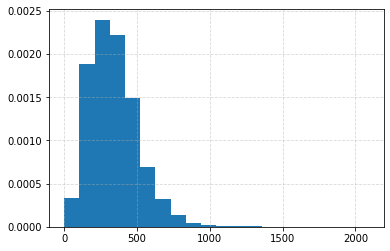

In [5]:
import matplotlib.pyplot as plt
a = 100
bins = int((max(totallength)-min(totallength))/a)
plt.hist(totallength,bins,density=1,stacked=True)
plt.grid(True,linestyle='--',alpha=0.5)
plt.show()

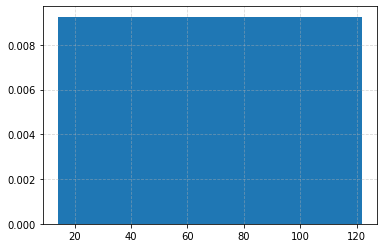

In [6]:
import matplotlib.pyplot as plt
a = 100
bins = int((max(totalabstractlength)-min(totalabstractlength))/a)
plt.hist(totalabstractlength,bins,density=1,stacked=True)
plt.grid(True,linestyle='--',alpha=0.5)
plt.show()

In [7]:
class dataset:
    def __init__(self,tokenizer,train_feat):
        self.tokenizer = tokenizer
        self.train_feat = train_feat
        
    def __len__(self):
        return len(self.train_feat)
    
    def __getitem__(self,index):
        item = self.train_feat[index]
        #item['generate_id'] = self.tokenizer.get_input_ids(item['generate_abstract'])
        #item['title_id'] = self.tokenizer.get_input_ids(item['title'])
        item['generate_id'] = self.tokenizer.tokenize(item['generate_abstract'])
        item['generate_id'] = ["[CLS]"]+item['generate_id']+["[SEP]"]
        item['generate_id'] = self.tokenizer.convert_tokens_to_ids(item['generate_id'])
        item['title_id'] = self.tokenizer.tokenize(item['title'])
        #item['title_id'] = ["[CLS]"]+item['title_id']+["[SEP]"]
        item['title_id'] = item['title_id']+["[SEP]"]
        item['title_id'] = self.tokenizer.convert_tokens_to_ids(item['title_id'])
        #item['generate_id'] = item['generate_id'][2:]
        #item['title_id'] = item['title_id'][2:]
        #'title','content','id','generate_abstract'
        return item

class Collate:
    def __init__(self,config_params):
        self.generate_abstract_max_length = config_params["generate_abstract_max_length"]
        self.title_max_length = config_params["title_max_length"]
        
    def __call__(self,batch_token):
        #'title','content','id','generate_abstract'
        token_result = []
        label_result = []
        abstract_result = []
        original_content_result = []
        generate_abstract_batch_length = max([len(token['generate_id']) for token in batch_token])
        generate_abstract_batch_length = min(generate_abstract_batch_length,self.generate_abstract_max_length)
        for index in range(len(batch_token)):
            if len(batch_token[index]['generate_id']) > generate_abstract_batch_length:
                batch_token[index]['generate_id'] = batch_token[index]['generate_id'][:generate_abstract_batch_length-1]+[batch_token[index]['generate_id'][-1]]
            else:
                for index1 in range(len(batch_token[index]['generate_id']),generate_abstract_batch_length):
                    batch_token[index]['generate_id'].append(0)
            token_result.append(batch_token[index]['generate_id'])
            abstract_result.append(batch_token[index]['title'])
            original_content_result.append(batch_token[index]['generate_abstract'])
        
        title_abstract_batch_length = max([len(token['title_id']) for token in batch_token])
        for index in range(len(batch_token)):
            if len(batch_token[index]['title_id']) > title_abstract_batch_length:
                batch_token[index]['title_id'] = batch_token[index]['title_id'][:title_abstract_batch_length-1]+[batch_token[index]['title_id'][-1]]
            else:
                for index1 in range(len(batch_token[index]['title_id']),title_abstract_batch_length):
                    batch_token[index]['title_id'].append(-100)
            label_result.append(batch_token[index]['title_id'])
        
        token_result = torch.tensor(token_result)
        label_result = torch.tensor(label_result)
        return token_result,label_result,abstract_result,original_content_result

In [8]:
train_params = {'batch_size':config_params["train_batch_size"],'shuffle':True,\
                'num_workers':1,'pin_memory':True,\
                'collate_fn':Collate(config_params=config_params)}
train_loader = DataLoader(dataset(t5tokenizer,train_feat),**train_params)
valid_params = {'batch_size':config_params["valid_batch_size"],'shuffle':False,\
                'num_workers':4,'pin_memory':True,\
                'collate_fn':Collate(config_params=config_params)}
valid_loader = DataLoader(dataset(t5tokenizer,valid_feat),**valid_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)
bestpoint = 0.0
totalnumber = 0
scaler = torch.cuda.amp.GradScaler()
for epoch in range(10):
    print('epoch = %d'%epoch)
    model.to(device)
    
    model.train()
    for batch_token,batch_label,batch_abstract,batch_content in tqdm(train_loader):
        batch_token = batch_token.to(device)
        batch_label = batch_label.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            result,loss = model(input_ids=batch_token,\
                            labels=batch_label,generate=False)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    totalrouge1 = 0.0
    totalrouge2 = 0.0
    totalrougel = 0.0
    totalpoint = 0.0
    totalnumber = 0
    model.eval()
    for batch_token,batch_label,batch_abstract,batch_content in tqdm(valid_loader):
        batch_token = batch_token.to(device)
        batch_label = batch_label.to(device)
        result_id = greedy_generate(model,mt5config,\
                                   batch_token,labels=None,max_length=120)
        result_id = result_id.tolist()
        for index in range(len(batch_abstract)):
            result_content = t5tokenizer.convert_ids_to_tokens(result_id[index])
            result_content = ''.join(result_content)
            result_content = result_content.replace("[SEP]","")
            result_content = result_content.replace("[PAD]","")
            
            currentpoint = compute_rouge(result_content,batch_abstract[index])
            valid_feat[totalnumber]['valid_text' ] = result_content
            #totalpoint = totalpoint+currentpoint
            totalrouge1 = totalrouge1+currentpoint['rouge-1']
            totalrouge2 = totalrouge2+currentpoint['rouge-2']
            totalrougel = totalrougel+currentpoint['rouge-l']
            totalpoint = 0.2*totalrouge1+0.4*totalrouge2+0.4*totalrougel
            totalnumber = totalnumber+1
    totalrouge1 = totalrouge1/totalnumber
    totalrouge2 = totalrouge2/totalnumber
    totalrougel = totalrougel/totalnumber
    totalpoint = totalpoint/totalnumber
    print('totalrouge1 = %f'%totalrouge1)
    print('totalrouge2 = %f'%totalrouge2)
    print('totalrougel = %f'%totalrougel)
    print('totalpoint = %f'%totalpoint)
    if totalpoint > bestpoint:
        bestpoint = totalpoint
        torch.save(model,'generate_best_score='+str(bestpoint)+'.pth')

epoch = 0


  0%|                                                   | 0/625 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.300 seconds.
Prefix dict has been built successfully.
100%|███████████████████████████████████████| 625/625 [1:04:05<00:00,  6.15s/it]


totalrouge1 = 0.408021
totalrouge2 = 0.209313
totalrougel = 0.369143
totalpoint = 0.312986
epoch = 1


100%|███████████████████████████████████████| 625/625 [1:00:40<00:00,  5.82s/it]


totalrouge1 = 0.415145
totalrouge2 = 0.216668
totalrougel = 0.376189
totalpoint = 0.320172
epoch = 2


100%|█████████████████████████████████████████| 625/625 [56:55<00:00,  5.47s/it]


totalrouge1 = 0.421933
totalrouge2 = 0.219298
totalrougel = 0.381460
totalpoint = 0.324690
epoch = 3


100%|█████████████████████████████████████████| 625/625 [55:49<00:00,  5.36s/it]


totalrouge1 = 0.425072
totalrouge2 = 0.221821
totalrougel = 0.384055
totalpoint = 0.327365
epoch = 4


100%|█████████████████████████████████████████| 625/625 [56:14<00:00,  5.40s/it]


totalrouge1 = 0.426496
totalrouge2 = 0.223137
totalrougel = 0.384838
totalpoint = 0.328489
epoch = 5


100%|█████████████████████████████████████████| 625/625 [53:58<00:00,  5.18s/it]


totalrouge1 = 0.430227
totalrouge2 = 0.226917
totalrougel = 0.388852
totalpoint = 0.332353
epoch = 6


100%|█████████████████████████████████████████| 625/625 [54:40<00:00,  5.25s/it]


totalrouge1 = 0.430880
totalrouge2 = 0.225681
totalrougel = 0.387785
totalpoint = 0.331562
epoch = 7


100%|█████████████████████████████████████████| 625/625 [52:28<00:00,  5.04s/it]


totalrouge1 = 0.435603
totalrouge2 = 0.231319
totalrougel = 0.393706
totalpoint = 0.337131
epoch = 8


100%|█████████████████████████████████████████| 625/625 [53:02<00:00,  5.09s/it]


totalrouge1 = 0.436028
totalrouge2 = 0.230988
totalrougel = 0.393383
totalpoint = 0.336954
epoch = 9


100%|█████████████████████████████████████████| 625/625 [52:32<00:00,  5.04s/it]


totalrouge1 = 0.438402
totalrouge2 = 0.233888
totalrougel = 0.397070
totalpoint = 0.340064


In [11]:
import codecs
with codecs.open("/home/xiaoguzai/程序/毕业设计/毕业设计数据/valid_generate_result.json",'w',encoding='utf-8') as obj:
    json.dump(valid_feat, obj, ensure_ascii=False)